# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
from lime import our_lime
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from pycocotools.coco import COCO
from shutil import copy

### SET RANDOM SEEDS FOR COMPARING ###
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
CAT_AND_DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat_and_dog_in_same_image'
CATVSDOG_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
ROOT_DIR = Path.cwd()

classes = ["cat", "dog"]

### COMPUTE DEVICE (CPU/GPU) ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### FUNCTIONS ###
def get_image(path):
    img_path_file = path
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
if not Path(CATVSDOG_CLASSIFIER_WEIGHT_PATH):
    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

Device: cuda


# Demo: ImageObject Class

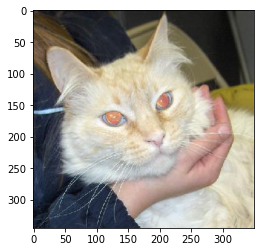

In [2]:
#pick random image
#random_image = get_image(CAT_IMG_PATH)
random_image = get_image(CAT_IMG_PATH)
#random_image = get_image(CAT_AND_DOG_IMG_PATH)

ImageObjectDemo = our_lime.ImageObject(random_image)
ImageObjectDemo.show()

# Image Classifier

In [3]:
#load CatVsDog weights into densenet architecture.
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

model.load_state_dict( torch.load(CATVSDOG_CLASSIFIER_WEIGHT_PATH, map_location = device) )

for param in model.parameters():
    param.requires_grad = False

model.eval()

#the data transformation used when training the CatVsDog classifier
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf

preprocess_transform = get_preprocess_transform()

# Demo: Explainer Class

In [4]:
explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)
explainer.segment_image(ImageObjectDemo)
#superpixels are saved
ImageObjectDemo.superpixels
print(np.shape(ImageObjectDemo.superpixels))

(124, 144)


# Demo: Generate Mask

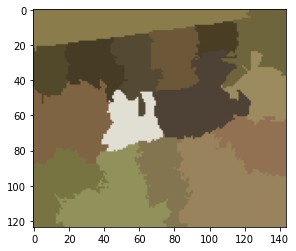

In [5]:
#set mask to to average superpixel value
explainer.mask_image(ImageObjectDemo)
plt.imshow(ImageObjectDemo.masked_image)

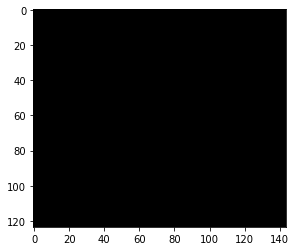

In [6]:
#set mask value to 0
explainer.mask_image(ImageObjectDemo, mask_value = 0)
plt.imshow(ImageObjectDemo.masked_image)

# Demo: Sample Superpixels

In [7]:
#create 3 samples
superpixel_samples, sampled_images = explainer.sample_superpixels(ImageObjectDemo, 4)

<class 'list'>
<class 'numpy.ndarray'>
(124, 144, 3)


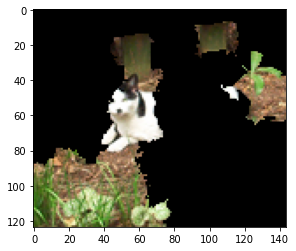

In [8]:
print(type(sampled_images))
#showing first sample
print(type(sampled_images[0]))
print(np.shape(sampled_images[0]))
plt.imshow(sampled_images[0])

# Demo: BlackBox IO

In [9]:
# blackbox output on sampled images
blackbox_out = explainer.map_blaxbox_io(sampled_images)
print(np.mean(blackbox_out, axis=0))
#blackbox output on original image
blackbox_out = explainer.map_blaxbox_io((ImageObjectDemo.original_image,))
print(blackbox_out)



[0.5702697 0.4297303]
[[0.7463519  0.25364807]]


# Demo: Explain Image

Class stats: cat
Intercept:0.696275327237326 R^2:0.3253219516842737 Prediction on ori. image [2.64553113]
Class stats: dog
Intercept:0.3037246960256559 R^2:0.3253219591215948 Prediction on ori. image [-1.64553146]


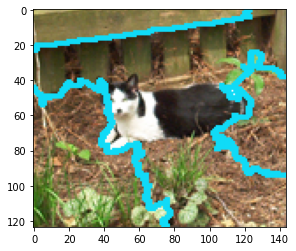

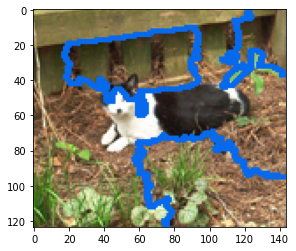

In [10]:
explainer.explain_image(ImageObjectDemo, 200, classes, top_labels = 2, num_superpixels = 10, display = True)


# Get Coco images and annotations for evaluation 

In [5]:
explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)
COCO_PATH = ROOT_DIR / 'data' / 'coco' / 'val2017' / 'val2017'
COCO_ANNOTATIONS_PATH = ROOT_DIR / 'data' / 'coco' / 'annotations_trainval2017' / 'annotations' / 'instances_val2017.json'
COCO_TARGET = ROOT_DIR / 'data' / 'coco' / 'images'
dog_binary_masks = explainer.get_coco_data_and_binary_masks(COCO_PATH, COCO_ANNOTATIONS_PATH, COCO_TARGET, 'dog')
cat_binary_masks = explainer.get_coco_data_and_binary_masks(COCO_PATH, COCO_ANNOTATIONS_PATH, COCO_TARGET, 'cat')
COCO_binary_masks = [ cat_binary_masks, dog_binary_masks ]

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


#  Evaluation

In [6]:
COCO_DIR = [ROOT_DIR / 'data' / 'coco' / 'images' / 'cat',
            ROOT_DIR / 'data' / 'coco' / 'images' / 'dog']

#nsamples = [i for i in range(1000, 5000, 2000)]
nsamples = [1000, 3000, 5000]
nsample_scores = list()

#go through differnt nsamples.
    #compute coverage on all dog + cat images. 
    #weigh and average all coverages.
    #append to nsample_scores

for nsample in nsamples:
    
    print(f"Nsamples: {nsample} for LIME algorithm")
    seg_sizes = list()
    coverages = list()
    for category_dir in COCO_DIR:
        count = 0
        img_files = list(category_dir.glob('*.jpg*'))
        category = os.path.basename(category_dir)
        class_idx = classes.index(category)
        coco_binary_masks = COCO_binary_masks[class_idx]
        print(f"Evaluating category: {category}\nDetected number of images: { len(img_files) }\n")
        
        for img_file in img_files:
            print(f"Evaluating {category} image: { os.path.basename(img_file) }...")
            img_path_file = category_dir / img_file
            with open(os.path.abspath(img_path_file), 'rb') as f:
                with Image.open(f) as img:
                    img.convert('RGB')
            
            img_object = our_lime.ImageObject(img)
            explainer.explain_image(img_object, nsample, classes, num_superpixels = 10)
            LIME_binary_mask = img_object.label_masks[class_idx]
            COCO_binary_mask = coco_binary_masks[os.path.basename(img_file)]
            
            coverage = explainer.coco_evaluation_score(LIME_binary_mask, COCO_binary_mask)
            coverages.append(coverage)
            print(f"LIME_COCO coverage --> {coverage}")
            
            print("Done.")
    avg_coverage = sum(coverages) / len(coverages)
    print(f"Score when using {nsample} samples ---> {avg_coverage} ")
    nsample_scores.append(avg_coverage)        

nsample_eval_results = list(zip(nsamples, nsample_scores))

Nsamples: 1000 for LIME algorithm
Evaluating category: cat
Detected number of images: 184

Evaluating cat image: 0.jpg...
LIME_COCO coverage --> 0.2691756095148608
Done.
Evaluating cat image: 1.jpg...


KeyboardInterrupt: 

In [13]:
nsample_eval_results

[(550, 0.0011774628447470278),
 (600, 0.0011613095775070865),
 (650, 0.0011658718701009698),
 (700, 0.0011642293763373121),
 (750, 0.0011772710125432721),
 (800, 0.0011717192635313015),
 (850, 0.0011763502295890624),
 (900, 0.0011841742328388902),
 (950, 0.0011459606771264301)]

In [ ]:
#save results
filename = ROOT_DIR / 'results' / '1000_and_1500_nsample_results.list' #whatever nsample u running
outfile = open(filename,'wb')
pickle.dump(nsample_eval_results, outfile)
outfile.close()
#HOW to load results
#import pickle
#filename = ROOT_DIR / 'results' / '25_30_nsample_results.list'
#infile = open(filename,'rb')
#results = pickle.load(infile)
#infile.close()
#print(results)